Slice TCA for T-maze session

In [1]:
# import
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import sys

# データ読み込み
data_dir = os.getenv("DATA_DIR")

git = os.getenv("GIT")
sys.path.append(git + "/neuroscience/general")
import mat2py

In [2]:
# whl 読み込み
Whl = np.loadtxt(r"H:\KenjiLinux150210\BuzsakiLabCopy\unit2\ec013.43\ec013.773\ec013.773.whl")


In [3]:
# whl から trial start time, stem 端に到達した時間を取得

# Whl (:,,0:2) のみを -1 = nanにして取り出す。
def Whl2whl(Whl):
    whl = Whl[:, 0:2]
    whl[whl==-1] = np.nan
    return whl

whl = Whl2whl(Whl)

# whl を gausswindowで smoothing nanが影響しないように処理
def smooth_whl(whl, filter_sigma=5):
    from scipy.ndimage import gaussian_filter
    # x座標とy座標を個別にフィルタリング
    x_data = whl[:, 0]
    y_data = whl[:, 1]

    # NaNをゼロに置き換え
    x_data_no_nan = np.nan_to_num(x_data, nan=0)
    y_data_no_nan = np.nan_to_num(y_data, nan=0)

    # NaNのマスク
    x_weights = ~np.isnan(x_data)
    y_weights = ~np.isnan(y_data)


    # データと重みマスクをそれぞれフィルタリング

    filtered_x = gaussian_filter(x_data_no_nan, sigma=filter_sigma)
    filtered_y = gaussian_filter(y_data_no_nan, sigma=filter_sigma)

    # 重みも同様にフィルタリング
    filtered_x_weights = gaussian_filter(x_weights.astype(float), sigma=filter_sigma)
    filtered_y_weights = gaussian_filter(y_weights.astype(float), sigma=filter_sigma)

    # 重みで正規化して、NaN部分を除いた平均を計算
    normalized_x = np.divide(filtered_x, filtered_x_weights, out=np.zeros_like(filtered_x), where=filtered_x_weights!=0)
    normalized_y = np.divide(filtered_y, filtered_y_weights, out=np.zeros_like(filtered_y), where=filtered_y_weights!=0)


    # 元のNaNの位置を再びNaNに戻す
    normalized_x[~x_weights] = np.nan
    normalized_y[~y_weights] = np.nan

    # フィルタリングされたx, yを再度組み合わせる
    normalized_data = np.vstack((normalized_x, normalized_y)).T

    return normalized_data

norm_whl = smooth_whl(whl)

# whl dataからtrial start time を取得
def get_trial_start_time(whl):
    # タイムスタンプ、x座標、y座標を含むデータフレームに変換
    # whl = (n,2) のnumpy配列 
    df = pd.DataFrame(whl, columns=['x', 'y'])
    df['time'] = np.arange(0, len(whl)*32/1250, 32/1250)  # 仮にタイムスタンプとしてインデックスを使用


    # 位置の定義
    home = [170, 85]
    stem_start = [155, 80]
    strm_end = [80, 80]
    left = [165, 40]
    right = [165, 120]

    home_radius = 10
    stem_radius = 5
    left_radius = 10
    right_radius = 10


    # 距離を計算する関数
    def calculate_distance(x1, y1, x2, y2):
        return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    # 各領域の判定関数
    def is_in_home(x, y):
        return calculate_distance(x, y, home[0], home[1]) <= home_radius
    
    def is_in_stem_start(x, y):
        return calculate_distance(x, y, stem_start[0], stem_start[1]) <= stem_radius
    
    def is_in_stem_end(x, y):
        return calculate_distance(x, y, strm_end[0], strm_end[1]) <= stem_radius

    def is_in_left(x, y):
        return calculate_distance(x, y, left[0], left[1]) <= left_radius

    def is_in_right(x, y):
        return calculate_distance(x, y, right[0], right[1]) <= right_radius

    # 周回の開始時刻を抽出
    # lap_times をobject型で初期化 stem_start, stem_end, target, homeを格納
    stem_start_times = np.array([])
    stem_end_times = np.array([])
    target_times = np.array([])
    home_times = np.array([])

    in_home = False
    in_stem_start = False
    in_stem_end = False
    in_target = False

    # データを順に処理して周回の開始時刻を抽出
    for index, row in df.iterrows():
        x, y = row['x'], row['y']
        
        if not in_home and is_in_home(x, y):
            # 最初にhomeに入ったとき
            in_home = True
            in_stem_start = False
            in_stem_end = False
            in_target = False

        if in_home and not in_stem_start and not in_stem_end and not in_target and is_in_stem_start(x, y):
            # homeからstem_startに行った場合
            in_stem_start = True
            stem_start_times = np.append(stem_start_times, row['time'])

        if in_home and in_stem_start and not in_stem_end and not in_target and is_in_stem_end(x, y):
            # homeから出てstem_startを通過してstem_endに行った場合
            in_stem_end = True
            stem_end_times = np.append(stem_end_times, row['time'])
        
        if in_home and in_stem_start and in_stem_end and not in_target and (is_in_left(x, y) or is_in_right(x, y)):
            # homeから出てstem_startを通過してstem_endを通過して左に行った場合
            in_target = True
            target_times = np.append(target_times, row['time'])
        
        if in_home and in_stem_start and in_stem_end and in_target and is_in_home(x, y):
            # homeに戻った場合
            in_home = False
            in_stem_start = False
            in_stem_end = False
            in_target = False
            home_times = np.append(home_times, row['time'])
    
    data_type = [('stem_start', 'f8'), ('stem_end', 'f8'), ('target', 'f8'), ('home', 'f8')]
    lap_times = np.array(list(zip(stem_start_times, stem_end_times, target_times, home_times)), dtype=data_type)

    return lap_times

lap_times = get_trial_start_time(norm_whl)


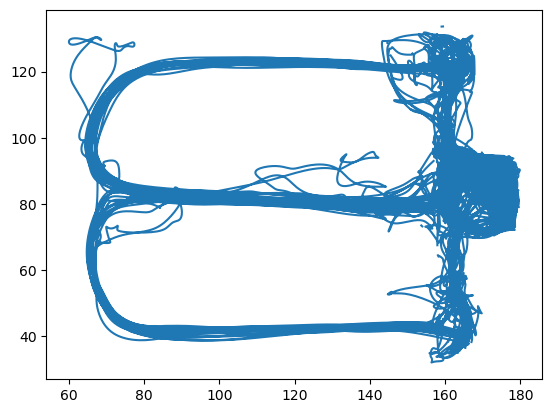

In [4]:
plt.plot(norm_whl[:, 0], norm_whl[:, 1])
plt.show()

In [5]:
lap_times.shape

(36,)

In [6]:
print(lap_times['stem_end']-lap_times['stem_start'])

[  3.1488  22.528   39.936    2.7136   1.8944   1.8944  52.864    2.1504
   2.048   29.9264 291.4816  21.1968   1.9712   2.0736   1.8944  48.9728
   1.8688  22.6048   2.5856  59.3664  33.8688   1.9456   2.2016 106.5472
   2.5088   4.3776   3.2256   2.4064  20.5568  28.1088   2.1504  48.2048
   3.1488   2.2528   1.536    2.304 ]


In [7]:
# res, clu data 読み込み
import mat2py
filename = 'ec013.773'
[Res, Clu] = mat2py.ResCluDataConnect2(filename)
Res = Res/20000

In [8]:
# resを 10ms bin で (trial, neurons, time) に変換
# stem_end 前1.5秒を取得 
def res2bin(Res, Clu, lap_times, bin_size=0.01):
    # バイナリ化
    # trial, neurons, max_trial_length のサイズでバイナリ化
    res_bin = np.full((lap_times.shape[0], len(np.unique(Clu)), int(1.5/bin_size)), np.nan)

    for i, stem_end in enumerate(lap_times['stem_end']):
        # 1 trial 中のhistogram edge bin

        # bin の edge を作成
        lap_edge = np.arange(stem_end-1.5, stem_end, bin_size)

        for j, neuron in enumerate(np.unique(Clu)):
            res_bin[i, j, 0:len(lap_edge)-1] = np.histogram(Res[(Res >= stem_end-1.5) & (Res < stem_end) & (Clu == neuron)], bins=lap_edge)[0]
    return res_bin



# lfp theta phase を 10ms bin で trial, 1, time に変換
# lfp は 1250hz想定
def lfp2bin(theta_pahse, lap_times, bin_size=0.01, lfp_sampling_rate=1250):
    # バイナリ化
    # trial, neurons, max_trial_length のサイズでバイナリ化
    lfp_bin = np.full((lap_times.shape[0], 1, int(1.5/bin_size)), np.nan)

    for i, stem_end in enumerate(lap_times['stem_end']):
        # 1 trial 中のhistogram edge bin

        # bin の edge を作成
        lap_edge = np.arange(0, 1.5, bin_size)



        # theta_phase[(stem_end-1.5)*1250:stem_end*1250]　の10ms ごとのmedianを取得
        theta_phase_trial = theta_pahse[int((stem_end-1.5)*lfp_sampling_rate):int(stem_end*lfp_sampling_rate)]
        theta_phase_bin = np.full((int(1.5/bin_size)), np.nan)
        for j, edge in enumerate(lap_edge):
            angles = theta_phase_trial[int(edge*lfp_sampling_rate):int((edge+bin_size)*lfp_sampling_rate)]
            complex_numbers = np.exp(1j * angles)
            # nanを除いて平均を取得
            mean_complex = np.mean(complex_numbers)
            mean_angle_rad = np.angle(mean_complex) 
            theta_phase_bin[j] = mean_angle_rad

        lfp_bin[i, 0, 0:len(lap_edge)] = theta_phase_bin
    return lfp_bin

In [ ]:
res_bin = res2bin(Res, Clu, lap_times)

# pickle で保存
with open(data_dir + '/res_bin.pkl', 'wb') as f:
    pickle.dump(res_bin, f)


In [10]:
Git = os.getenv("GIT")
#パス追加
import sys
sys.path.append(Git + '/neuroscience/general')
import mat2py as m2p

fname = r"H:\KenjiLinux150210\BuzsakiLabCopy\unit2\ec013.43\ec013.773\ec013.773.eeg"
numch = 65
chselect = 12
lfp = m2p.read_single_ch(fname, numch, chselect)

theta_phase, Amp, Tot = m2p.theta_phase(lfp, FreqRange=[4, 10], FilterOrd=4, SampleRate=1250)


In [ ]:
angles = theta_phase[0:12]
complex_numbers = np.exp(1j * angles)
mean_complex = np.mean(complex_numbers)
mean_angle_rad = np.angle(mean_complex)

print(mean_angle_rad)


2.2550521412266376


In [12]:
lfp_bin = lfp2bin(theta_phase, lap_times, bin_size=0.01)

In [17]:
# pickle で保存
with open(data_dir + '/lfp_bin.pkl', 'wb') as f:
    pickle.dump(lfp_bin, f)

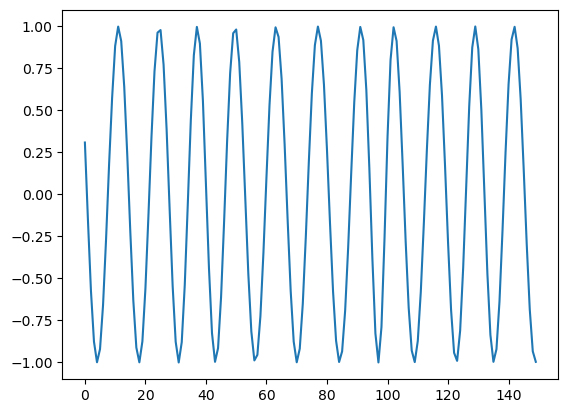

In [19]:
plt.plot(np.sin(lfp_bin[0, 0, :]))
plt.show()